# Benchmark de Coloration de Graphe


## 1. Parsing des instances de coloration

Dans cette section, nous allons lire les fichiers d'instances au format `.col` depuis le répertoire `instances/instances/instances_coloration/`.

Chaque fichier `.col` décrit un graphe. Nous allons convertir ces graphes en Problèmes de Satisfaction de Contraintes (CSP) au format que notre solveur peut comprendre.

Les étapes sont les suivantes :
1.  Lire un fichier `.col` pour en extraire le nombre de nœuds et la liste des arêtes.
2.  Définir un problème CSP équivalent :
    *   Chaque **nœud** devient une **variable** CSP.
    *   Le **domaine** de chaque variable est l'ensemble des couleurs disponibles (par exemple, de 1 à `k`).
    *   Chaque **arête** `(u, v)` du graphe devient une **contrainte** `variable_u != variable_v`.
3.  Écrire le CSP résultant dans un fichier `.csp` dans le répertoire `instances/instances/`.


In [1]:
import os
import re
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random

# Chemins vers les répertoires importants
INSTANCES_COLORATION_DIR = os.path.abspath('../instances/instances/instances_jssp/')
INSTANCES_CSP_DIR = os.path.abspath('../instances/instances/')
SOLVER_PATH = os.path.abspath('../Solver/CPSolver')
SOLUTIONS_DIR = os.path.abspath('./solutions/')

# Créer le répertoire pour les solutions si nécessaire
os.makedirs(SOLUTIONS_DIR, exist_ok=True)
os.makedirs(INSTANCES_CSP_DIR, exist_ok=True)

print(f"Répertoire des instances dejssp : {INSTANCES_COLORATION_DIR}")
print(f"Répertoire des instances CSP : {INSTANCES_CSP_DIR}")
print(f"Chemin du solveur : {SOLVER_PATH}")
print(f"Répertoire des solutions : {SOLUTIONS_DIR}")

Répertoire des instances dejssp : c:\Users\Erwann\Documents\MPRO\PPC\CPSolver\instances\instances\instances_jssp
Répertoire des instances CSP : c:\Users\Erwann\Documents\MPRO\PPC\CPSolver\instances\instances
Chemin du solveur : c:\Users\Erwann\Documents\MPRO\PPC\CPSolver\Solver\CPSolver
Répertoire des solutions : c:\Users\Erwann\Documents\MPRO\PPC\CPSolver\solutions\solutions


## Chargement du fichier de benchmark pour la détermination de k

Nous allons charger le fichier `coloration_bk.csv` qui contient des informations sur les instances, notamment le nombre minimum de couleurs (`k`) connu pour certaines d'entre elles. Ce `k` sera utilisé en priorité pour la résolution. Si une instance n'est pas dans ce fichier ou n'a pas de `k` défini, nous utiliserons l'heuristique `degré maximum + 1`.


In [2]:
# Chemin vers le CSV de benchmark
BENCHMARK_CSV_PATH = os.path.abspath('./jssp_bk.csv')
print(f"Chemin du CSV de benchmark : {BENCHMARK_CSV_PATH}")

# Charger le CSV de benchmark
try:
    bk_df = pd.read_csv(BENCHMARK_CSV_PATH)
    # Remplacer les '?' et les valeurs vides par NaN pour une gestion plus facile
    # bk_df['min_colors_required'] = pd.to_numeric(bk_df['min_colors_required'], errors='coerce')
    # bk_df.set_index('instance_name', inplace=True)
    print("Fichier coloration_bk.csv chargé avec succès.")
    # display(bk_df.head())
except FileNotFoundError:
    print("Fichier coloration_bk.csv non trouvé. Le k sera basé sur le degré maximum + 1.")
    bk_df = None


Chemin du CSV de benchmark : c:\Users\Erwann\Documents\MPRO\PPC\CPSolver\solutions\jssp_bk.csv
Fichier coloration_bk.csv non trouvé. Le k sera basé sur le degré maximum + 1.


In [51]:
def parse_col_to_csp(col_path, csp_path, num_colors):
    """
    Lit un fichier .col, le convertit en un fichier .csp et calcule le degré maximum.

    Args:
        col_path (str): Chemin vers le fichier d'instance .col.
        csp_path (str): Chemin vers le fichier de sortie .csp.
        num_colors (int): Nombre de couleurs à utiliser pour le domaine des variables.

    Returns:
        int: Le degré maximum du graphe.
    """
    nodes = 0
    edges = []
    
    with open(col_path, 'r') as f:
        for line in f:
            if line.startswith('c'):
                continue
            if line.startswith('p edge'):
                parts = line.split()
                nodes = int(parts[2])
            elif line.startswith('e'):
                parts = line.split()
                u, v = int(parts[1]), int(parts[2])
                # Les variables CSP sont 0-indexées, les noeuds .col sont 1-indexés
                edges.append((u - 1, v - 1))

    # Calcul du degré de chaque nœud pour trouver le degré maximum
    degrees = [0] * nodes
    for u, v in edges:
        degrees[u] += 1
        degrees[v] += 1
    max_degree = max(degrees) if degrees else 0

    with open(csp_path, 'w') as f:
        f.write(f"# Graph coloring problem from {os.path.basename(col_path)}\n")
        f.write(f"# Variables: {nodes}, Domain size: {num_colors}\n\n")

        # Nombre de variables
        f.write(f"{nodes}\n\n")

        # Domaines des variables
        f.write("# Variable domains (variable_id min_value max_value)\n")
        for i in range(nodes):
            f.write(f"{i} 1 {num_colors}\n")
        f.write("\n")

        # Contraintes
        f.write(f"{len(edges)}\n\n")
        f.write("# Constraints (var1 var2 (value1,value2) ...)\n")
        
        # Générer les paires de valeurs autorisées pour une contrainte !=
        allowed_pairs = []
        for c1 in range(1, num_colors + 1):
            for c2 in range(1, num_colors + 1):
                if c1 != c2:
                    allowed_pairs.append(f"({c1},{c2})")
        allowed_pairs_str = " ".join(allowed_pairs)

        for u, v in edges:
            f.write(f"{u} {v} {allowed_pairs_str}\n")
            
    return max_degree

### Test du parser

Nous allons tester le parser sur une instance pour vérifier que la conversion se passe bien. Nous utiliserons `david.col`. 
Pour un problème de coloration de graphe, une borne supérieure pour le nombre de couleurs nécéssaire (le nombre chromatique) est `degré_maximum + 1`. 
Nous allons utiliser cette heuristique pour fixer le nombre de couleurs `k` pour notre problème CSP.


In [52]:
# Test sur une instance
instance_name = 'jean.col'
col_file = os.path.join(INSTANCES_COLORATION_DIR, instance_name)
csp_file = os.path.join(INSTANCES_CSP_DIR, instance_name.replace('.col', '.csp'))

if os.path.exists(col_file):
    # On calcule k (nombre de couleurs) basé sur le degré maximum + 1
    max_deg = parse_col_to_csp(col_file, csp_file, 1) # Appel initial pour obtenir max_deg
    k = 10
    print(f"Instance: {instance_name}")
    print(f"Degré maximum trouvé : {max_deg}")
    print(f"Nombre de couleurs utilisé (k) : {k}")
    
    # On re-génère le CSP avec le bon nombre de couleurs
    parse_col_to_csp(col_file, csp_file, k)
    
    print(f"Fichier .col '{col_file}' converti en '{csp_file}' avec k={k} couleurs.")

    # Afficher les 20 premières lignes du fichier CSP généré pour vérification
    with open(csp_file, 'r') as f:
        for i, line in enumerate(f):
            if i >= 20:
                break
            print(line, end='')
else:
    print(f"Le fichier d'instance {col_file} n'a pas été trouvé.")

Instance: jean.col
Degré maximum trouvé : 72
Nombre de couleurs utilisé (k) : 10
Fichier .col '/home/madoff/CPSolver/instances/instances/instances_coloration/jean.col' converti en '/home/madoff/CPSolver/instances/instances/jean.csp' avec k=10 couleurs.
# Graph coloring problem from jean.col
# Variables: 80, Domain size: 10

80

# Variable domains (variable_id min_value max_value)
0 1 10
1 1 10
2 1 10
3 1 10
4 1 10
5 1 10
6 1 10
7 1 10
8 1 10
9 1 10
10 1 10
11 1 10
12 1 10
13 1 10


## 2. Résolution des instances CSP

Maintenant que nous pouvons convertir les instances `.col` en `.csp`, nous allons utiliser le solveur C++ pour les résoudre.

Nous allons définir une fonction qui :
1.  Prend en entrée le chemin d'un fichier `.csp`.
2.  Construit et exécute la commande pour appeler le solveur.
3.  Capture la sortie du solveur (statistiques, temps, etc.).
4.  Parse cette sortie pour en extraire les informations pertinentes.


In [53]:
def parse_solver_output(output_text):
    """Parse la sortie du solver pour extraire les informations."""
    data = {
        'solving_time_ms': 0,
        'nodes_explored': 0,
        'solutions_found': 0,
        'status': 'unknown'
    }
    
    # Utiliser '\n' pour diviser les lignes de la sortie standard.
    # Les expressions régulières ont été rendues plus spécifiques pour éviter les erreurs.
    for line in output_text.split('\n'):
        if "Solving time:" in line:
            match = re.search(r'Solving time: (\d+)ms', line)
            if match:
                data['solving_time_ms'] = int(match.group(1))
        elif "Nodes explored:" in line:
            match = re.search(r'Nodes explored: (\d+)', line)
            if match:
                data['nodes_explored'] = int(match.group(1))
        elif "Solutions found:" in line:
            match = re.search(r'Solutions found: (\d+)', line)
            if match:
                data['solutions_found'] = int(match.group(1))
        elif "Resolution status:" in line:
            status_match = re.search(r'Resolution status:\s*(.*)', line)
            if status_match:
                data['status'] = status_match.group(1).strip()
                
    return data

def run_solver(csp_path, solution_path, timeout=30):
    """Exécute le solveur sur un fichier CSP et retourne les statistiques."""
    
    cmd = [
        SOLVER_PATH,
        csp_path,
        '-t', str(timeout),
        '-f',  # Arrêter à la première solution
        '-o', solution_path
    ]
    
    try:
        result = subprocess.run(
            cmd,
            capture_output=True,
            text=True,
            timeout=timeout + 5
        )
        
        if result.returncode != 0:
            print(f"  Erreur lors de l'exécution du solveur sur {os.path.basename(csp_path)}:")
            print(result.stderr)
            return {'status': 'error', 'instance': os.path.basename(csp_path)}

        stats = parse_solver_output(result.stdout)
        stats['instance'] = os.path.basename(csp_path).replace('.csp', '')
        
        return stats

    except subprocess.TimeoutExpired:
        print(f"  Timeout pour l'instance {os.path.basename(csp_path)}")
        return {'status': 'timeout', 'instance': os.path.basename(csp_path)}
    except Exception as e:
        print(f"  Une erreur inattendue est survenue: {e}")
        return {'status': 'unexpected_error', 'instance': os.path.basename(csp_path)}

### Exécution sur toutes les instances

Nous allons maintenant itérer sur tous les fichiers `.col` du répertoire d'instances, les convertir et lancer le solveur. Les résultats seront stockés dans un DataFrame `pandas` pour une analyse facile.


In [54]:
all_results = []
# On s'assure de lister tous les types de fichiers d'instances
col_files = [f for f in os.listdir(INSTANCES_COLORATION_DIR) if f.endswith(('.col', '.col.b'))]

for instance_name in sorted(col_files):
    print(f"Traitement de l'instance : {instance_name}")
    
    col_path = os.path.join(INSTANCES_COLORATION_DIR, instance_name)
    
    # Générer des noms de fichiers de sortie propres
    base_name = instance_name.replace('.col.b', '').replace('.col', '')
    csp_path = os.path.join(INSTANCES_CSP_DIR, f"{base_name}.csp")
    solution_path = os.path.join(SOLUTIONS_DIR, f"{base_name}.sol")
    
    # 1. Déterminer k et parser .col -> .csp
    try:
        k = None
        # Chercher k dans le DataFrame du benchmark
        if bk_df is not None and instance_name in bk_df.index:
            k_from_csv = bk_df.loc[instance_name, 'min_colors_required']
            if pd.notna(k_from_csv):
                k = int(k_from_csv)
                print(f"  k={k} trouvé dans coloration_bk.csv.")
        
        # Si k n'est pas trouvé, on utilise l'heuristique
        if k is None:
            max_deg = parse_col_to_csp(col_path, csp_path, 1) # Appel pour obtenir max_deg
            k = max_deg + 1
            print(f"  k non trouvé dans le CSV. Utilisation de k = max_degree + 1 = {k}.")

        # Générer le CSP final avec la bonne valeur de k
        parse_col_to_csp(col_path, csp_path, k)
        print(f"  Instance convertie en CSP avec k={k} couleurs.")

    except Exception as e:
        print(f"  Erreur lors de la conversion de {instance_name}: {e}")
        continue
        
    # 2. Lancer le solveur
    result = run_solver(csp_path, solution_path, timeout=5)
    result['k'] = k
    all_results.append(result)
    
    if result.get('status') not in ['error', 'timeout', 'unexpected_error']:
        print(f"  Résolution terminée. Statut : {result.get('status')}, Solutions : {result.get('solutions_found')}, Temps : {result.get('solving_time_ms')}ms")

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame(all_results)
if not results_df.empty:
    results_df = results_df[['instance', 'k', 'status', 'solutions_found', 'solving_time_ms', 'nodes_explored']]

print("\\n--- Résultats du Benchmark ---")
print(results_df.to_string())

Traitement de l'instance : DSJC1000.1.col.b
  Erreur lors de la conversion de DSJC1000.1.col.b: 'utf-8' codec can't decode byte 0x85 in position 490: invalid start byte
Traitement de l'instance : DSJC1000.5.col.b
  Erreur lors de la conversion de DSJC1000.5.col.b: 'utf-8' codec can't decode byte 0x80 in position 469: invalid start byte
Traitement de l'instance : DSJC1000.9.col.b
  Erreur lors de la conversion de DSJC1000.9.col.b: 'utf-8' codec can't decode byte 0x80 in position 468: invalid start byte
Traitement de l'instance : DSJC125.1.col.b
  Erreur lors de la conversion de DSJC125.1.col.b: 'utf-8' codec can't decode byte 0x80 in position 467: invalid start byte
Traitement de l'instance : DSJC125.5.col.b
  Erreur lors de la conversion de DSJC125.5.col.b: 'utf-8' codec can't decode byte 0x80 in position 464: invalid start byte
Traitement de l'instance : DSJC125.9.col.b
  Erreur lors de la conversion de DSJC125.9.col.b: 'utf-8' codec can't decode byte 0x80 in position 465: invalid sta

  Résolution terminée. Statut : First solution found, Solutions : 1, Temps : 1445ms
Traitement de l'instance : david.col
  k=11 trouvé dans coloration_bk.csv.
  Instance convertie en CSP avec k=11 couleurs.
  Résolution terminée. Statut : First solution found, Solutions : 1, Temps : 537ms
Traitement de l'instance : flat1000_50_0.col.b
  k=50 trouvé dans coloration_bk.csv.
  Erreur lors de la conversion de flat1000_50_0.col.b: 'utf-8' codec can't decode byte 0x80 in position 587: invalid start byte
Traitement de l'instance : flat1000_60_0.col.b
  k=60 trouvé dans coloration_bk.csv.
  Erreur lors de la conversion de flat1000_60_0.col.b: 'utf-8' codec can't decode byte 0xb0 in position 591: invalid start byte
Traitement de l'instance : flat1000_76_0.col.b
  k=76 trouvé dans coloration_bk.csv.
  Erreur lors de la conversion de flat1000_76_0.col.b: 'utf-8' codec can't decode byte 0x80 in position 590: invalid start byte
Traitement de l'instance : flat300_20_0.col.b
  k=20 trouvé dans colora

## 3. Visualisation des solutions

Pour visualiser le résultat de la coloration, nous allons implémenter une fonction qui :
1.  Lit un fichier de solution `.sol` pour obtenir la couleur de chaque nœud.
2.  Lit le fichier d'instance `.col` correspondant pour reconstruire le graphe.
3.  Utilise `networkx` et `matplotlib` pour dessiner le graphe avec les nœuds colorés.

Nous choisirons ensuite une instance résolue au hasard pour afficher sa solution.


In [55]:
def parse_solution_file(solution_path):
    """Parse un fichier de solution pour extraire l'assignation des couleurs."""
    
    colors = {}
    if not os.path.exists(solution_path):
        return None
        
    with open(solution_path, 'r') as f:
        for line in f:
            # On cherche une ligne qui n'est pas un commentaire et qui contient une assignation
            if line.startswith('#') or '=' not in line:
                continue
            
            # On a trouvé la ligne de solution probable
            parts = line.strip().split()
            for part in parts:
                try:
                    var, value = part.split('=')
                    colors[int(var)] = int(value)
                except ValueError:
                    # Ignore les parties mal formées qui ne peuvent pas être décompressées ou converties.
                    print(f"  Avertissement: partie de la solution mal formée ignorée : '{part}'")

            # Si on a trouvé des couleurs, on arrête. On assume qu'il n'y a qu'une ligne de solution.
            if colors:
                break
            
    return colors

def plot_colored_graph(col_path, colors, instance_name):
    """Dessine un graphe coloré à partir d'un fichier .col et d'une solution."""
    
    G = nx.Graph()
    with open(col_path, 'r') as f:
        for line in f:
            if line.startswith('p edge'):
                parts = line.split()
                num_nodes = int(parts[2])
                G.add_nodes_from(range(num_nodes))
            elif line.startswith('e'):
                parts = line.split()
                u, v = int(parts[1]) - 1, int(parts[2]) - 1
                G.add_edge(u, v)

    if not colors:
        print("Aucune solution de coloration à afficher.")
        # Dessiner le graphe sans couleurs
        node_colors = 'gray'
    else:
        # Créer la liste de couleurs pour le plot
        node_colors = [colors.get(node, 0) for node in G.nodes()]

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.jet, node_size=500, font_size=8)
    plt.title(f"Graphe coloré pour l'instance : {instance_name}", fontsize=16)
    plt.show()

Affichage d'une solution pour l'instance : myciel5.col


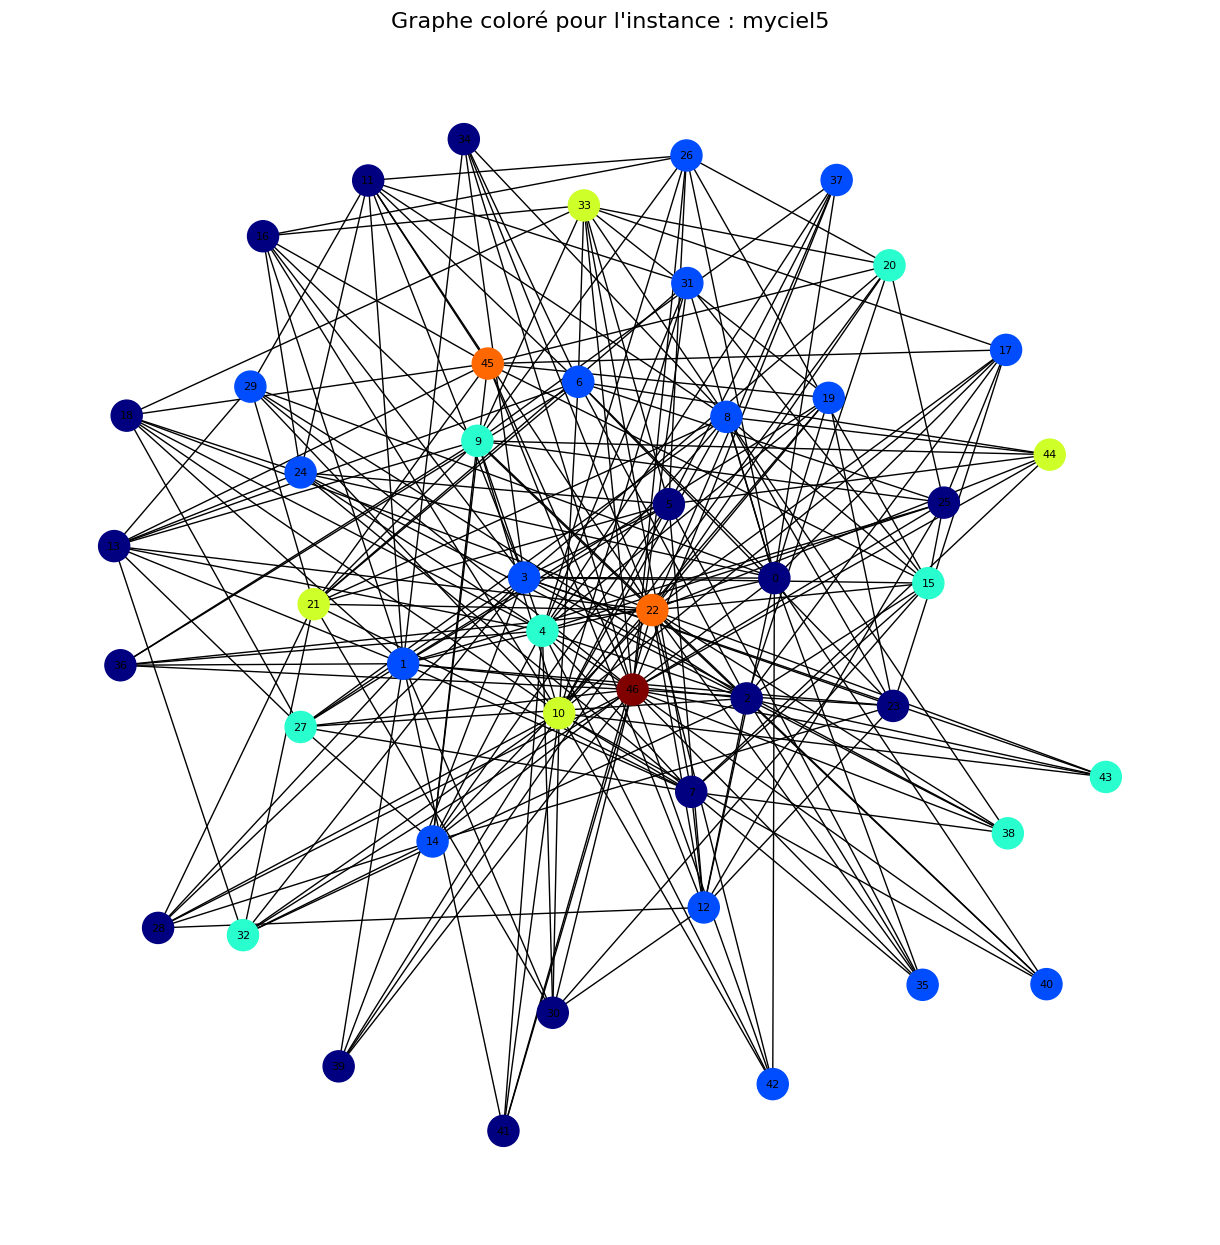

In [56]:
# Choisir une instance résolue au hasard pour la visualisation
solved_instances = results_df[results_df['solutions_found'] > 0]

if not solved_instances.empty:
    random_instance_name = solved_instances.sample(1).iloc[0]['instance']
    
    print(f"Affichage d'une solution pour l'instance : {random_instance_name}.col")
    
    col_file_to_plot = os.path.join(INSTANCES_COLORATION_DIR, f"{random_instance_name}.col")
    solution_file_to_plot = os.path.join(SOLUTIONS_DIR, f"{random_instance_name}.sol")
    
    # Parser la solution
    color_map = parse_solution_file(solution_file_to_plot)
    
    if color_map:
        # Afficher le graphe
        plot_colored_graph(col_file_to_plot, color_map, random_instance_name)
    else:
        print(f"Le fichier solution '{solution_file_to_plot}' est vide ou n'a pas pu être lu.")

else:
    print("Aucune instance n'a été résolue avec succès, impossible d'afficher une solution.")